Epoch 1/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.2972 - acc: 0.9096 - val_loss: 0.1028 - val_acc: 0.9707
Epoch 2/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.1562 - acc: 0.9530 - val_loss: 0.0904 - val_acc: 0.9738
Epoch 3/3
4500/4500 [==============================] - 5s 1ms/step - loss: 0.1248 - acc: 0.9624 - val_loss: 0.0818 - val_acc: 0.9760
Detected Postal Code:  4026
Postal Code:  4026
City:  Debrecen
Administrative Region:  Hajdú-Bihar County
Population:  4,805
Area:  0.93 km²


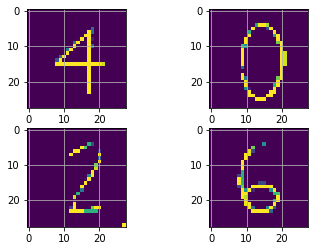

In [11]:
import tensorflow as tf
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from keras.models import load_model
import pymongo

postalCodeDigits = []
detectedImg = []
noOfDigit = 4
dataset = tf.keras.datasets.mnist

# Split dataset into train, test
(X_train, y_train), (X_test, y_test) = dataset.load_data()

# Normalize value to b/w 0and1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape train and test samples
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Convolutional Neural Network Model (CNN)
def myModel():
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

    # Fit the model
    history = model.fit(X_train, y_train, epochs=3, batch_size=12, validation_split=0.1)

    # Make prediction
    # plt.imshow(X_test[1255].reshape(28, 28), cmap='gray')
    # plt.xlabel(y_test[1255])
    # plt.ylabel(np.argmax(model.predict(X_test)[1255]))

    model.save('digit_trained.h5')
    return model

# OpenCV for capture and predicting through webcam
# Reading Postal code
def readingDigit(model):
    cap = cv2.VideoCapture(0)
    cap.set(3, 640)  # width
    cap.set(4, 480)  # height
    cap.set(10, 100)  # brightness
    while True:
        # read image
        success, img = cap.read()
        # crop the image
        img = img[200:400, 200:400]
        #convert to gray scale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # convert gray scale to binary image
        _, gray_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)
        # show binary image
        cv2.imshow("Thresholded Image", gray_img)
        # resize the image
        gray_img = cv2.resize(gray_img, (28, 28))
        # reshape the matrix
        reshaped_gray = gray_img.reshape(1, 784)
        # predict digit
        detectedResult = np.argmax(model.predict(reshaped_gray))
        result = 'Result: {}'.format(detectedResult)
        cv2.putText(img, org=(25, 25), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, text=result, color=(255, 0, 0),
                    thickness=1)
        cv2.imshow("Image", img)

        if cv2.waitKey(1) == 13:
            break
    cap.release()
    cv2.destroyAllWindows()
    return detectedResult, gray_img

def readingPostalCode(noOfDigit):
    for i in range(0, noOfDigit):
        d, img = readingDigit(model)
        postalCodeDigits.append(d)
        detectedImg.append(img)
    detectedCode = ''.join(str(d) for d in postalCodeDigits)
    print("Detected Postal Code: ", detectedCode)
    return detectedCode, detectedImg

# Mongo DB connection
def retrievingData(detectedCode):
    conn = pymongo.MongoClient()
    db = conn['postal_code']
    coll = db['postal_code_details']

    query = coll.find_one({'postal_code': int(detectedCode)}, {'_id': 0})

    if query == None:
        print("Wrong postal code! The postal code doesn't belong to Debrecen.")
    else:
        print("Postal Code: ",query['postal_code'])
        print("City: ",query['city'])
        print("Administrative Region: ",query['administrative_region'])
        print("Population: ",query['population'])
        print("Area: ",query['area'])
    conn.close()

def plotImg(images):
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(images[0])
    # axarr[0,0].set_title('First Digit')
    axarr[0,0].grid(True)
    axarr[0,1].imshow(images[1])
    # axarr[0,1].set_title('Second Digit')
    axarr[0,1].grid(True)
    axarr[1,0].imshow(images[2])
    # axarr[1,0].set_title('Third Digit')
    axarr[1,0].grid(True)
    axarr[1,1].imshow(images[3])
    # axarr[1,1].set_title('Fourth Digit') 
    axarr[1,1].grid(True)
    plt.show()

model = myModel()
code, images = readingPostalCode(4)
retrievingData(code)
plotImg(images)